In [1]:
import numpy as np
from skimage import io, util, measure, transform
from scipy.ndimage import gaussian_filter
from scipy import interpolate
import pandas as pd
from imageUtils import normalize_image_intensity_signed

from os import path
import stackview
import matplotlib.pyplot as plt
from scipy.interpolate import NearestNDInterpolator

from measurements import get_mesh_from_bm_image,get_tissue_curvatures
from trimesh import Trimesh
import pyvista as pv
pv.set_jupyter_backend('trame')

In [3]:

dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/09-27-2025 MemGFP fold logevity/F1 cage 3015 MemGFP NoFUCCI/R2/'
dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/10-03-2025 Cdh5-RFP blood vessels/Male 6121/Left paw R2'

t0 = io.imread(path.join(dirname,'0. Day 0/height_image.tif'))
t1 = io.imread(path.join(dirname,'1. Day 11/height_image.tif'))

# stackview.orthogonal(t0, zoom_factor=0.5,continuous_update=True)


In [4]:
dx = 0.2919921875
dz = 0.7

#Trim to the 'center' to avoid the artifacts on edges
Y_trim = slice(200,800)
X_trim = slice(200,800)
t0_crop = t0[:,Y_trim,X_trim]
t1_crop = t1[:,Y_trim,X_trim]

gridY,gridX = np.meshgrid(range(800),range(800))

t0_mesh = get_mesh_from_bm_image(t0_crop,spacing=[dz,dx,dx])
t0_curvature,_ = get_tissue_curvatures(t0_mesh,kappa=6)

t1_mesh = get_mesh_from_bm_image(t1_crop,spacing=[dz,dx,dx])
t1_curvature,_ = get_tissue_curvatures(t1_mesh,kappa=6)


KeyboardInterrupt: 

In [37]:
pl = pv.Plotter(notebook=True)
pl.add_mesh(t0_mesh)
pl.show(jupyter_backend='trame')

Widget(value='<iframe src="http://localhost:51892/index.html?ui=P_0x3f414d0a0_7&reconnect=auto" class="pyvista…

In [5]:
pl = pv.Plotter(notebook=True)
pl.add_mesh(t1_mesh)
pl.show(jupyter_backend='trame')

Widget(value='<iframe src="http://localhost:51892/index.html?ui=P_0x31af02b40_1&reconnect=auto" class="pyvista…

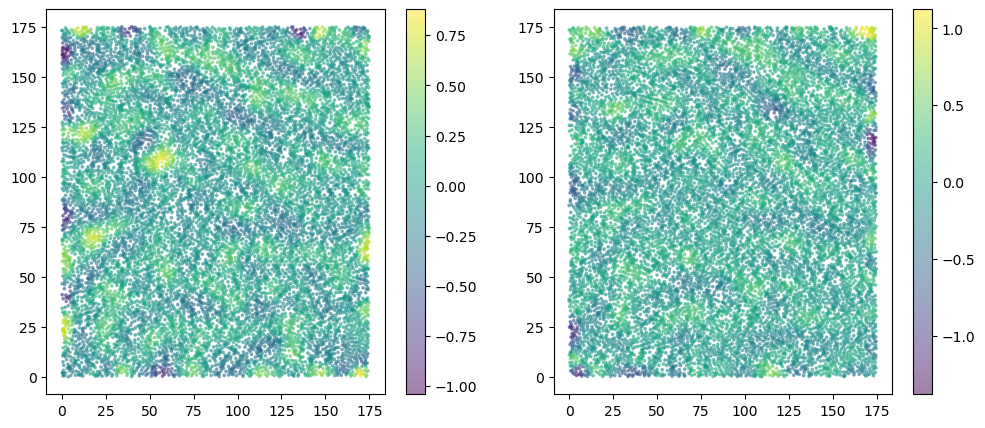

In [38]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.subplot(1,2,1)
plt.scatter(t0_mesh.vertices[:,0],
            t0_mesh.vertices[:,1],
            c=t0_curvature,s=3,alpha=0.5)
plt.colorbar()
plt.subplot(1,2,2)
plt.scatter(t1_mesh.vertices[:,0],
            t1_mesh.vertices[:,1],
            c=t1_curvature,s=3,alpha=0.5)
plt.colorbar()

In [39]:
ZZ,XX,_ = t0.shape
# Match the 'pixel grid' to the 'microns grid' used by Trimesh
pixel_gridX = np.arange(XX)
# gridY,gridX = np.meshgrid()
pixel_gridX_crop = pixel_gridX[X_trim]
pixel_gridY_crop = pixel_gridX[Y_trim]

micron_Xmin,micron_Xmax = t0_mesh.vertices[:,1].min(),t0_mesh.vertices[:,1].max()
micron_Ymin,micron_Ymax = t0_mesh.vertices[:,0].min(),t0_mesh.vertices[:,0].max()

Ngrid = X_trim.stop - X_trim.start
micron_gridX = np.linspace(0,micron_Xmax,Ngrid)
micron_gridY = np.linspace(0,micron_Ymax,Ngrid)
micron_gridXX,micron_gridYY = np.meshgrid( micron_gridX, micron_gridY)
Ngrid

600

(600, 600)

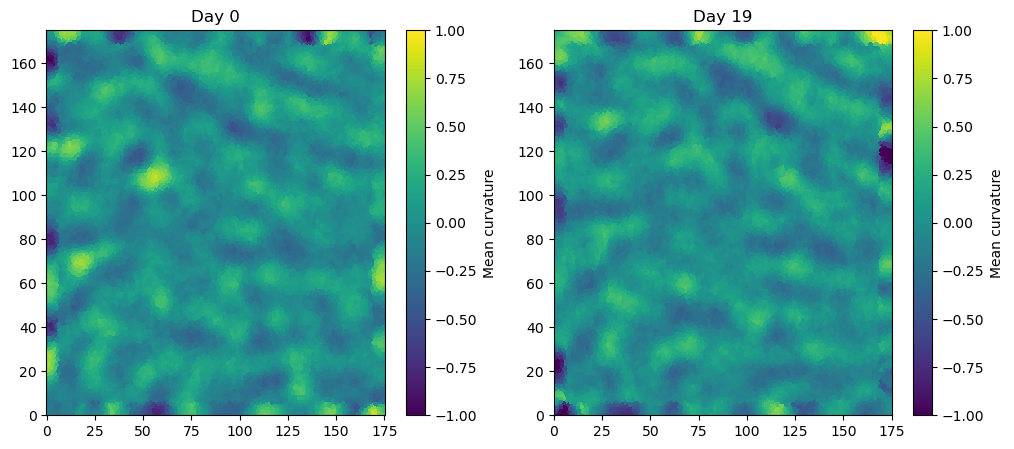

In [40]:

interp = NearestNDInterpolator(list(zip(t0_mesh.vertices[:,0], t0_mesh.vertices[:,1])), t0_curvature)
plt.subplot(1,2,1)
plt.title('Day 0')
t0_curve_grid = interp( micron_gridXX,micron_gridYY )
plt.pcolor(micron_gridXX,micron_gridY,t0_curve_grid)
plt.clim([-1,1])
plt.colorbar(label='Mean curvature')

interp = NearestNDInterpolator(list(zip(t1_mesh.vertices[:,0], t1_mesh.vertices[:,1])), t1_curvature)
plt.subplot(1,2,2)
plt.title('Day 19')
t1_curve_grid = interp( micron_gridXX,micron_gridYY )
plt.pcolor(micron_gridXX,micron_gridYY,t1_curve_grid)
plt.clim([-1,1])

plt.colorbar(label='Mean curvature')
t1_curve_grid.shape

In [41]:
# Export curvature images

# Pad out the cropped out region with 0
t0_reconstructed = np.zeros((XX,XX),dtype=float)
t1_reconstructed = np.zeros((XX,XX),dtype=float)

t0_reconstructed[Y_trim,X_trim] = t0_curve_grid
t1_reconstructed[Y_trim,X_trim] = t1_curve_grid

io.imsave(path.join(dirname,'0. Day 0/curvature.tif'),util.img_as_int(normalize_image_intensity_signed(t0_reconstructed)))
io.imsave(path.join(dirname,'1. Day 11/curvature.tif'),util.img_as_int(normalize_image_intensity_signed(t1_reconstructed)))

np.savez(path.join(dirname,'0. Day 0/curvature.npz'),t0_reconstructed)
np.savez(path.join(dirname,'1. Day 11/curvature.npz'),t1_reconstructed)

TypeError: Dimensions of C (600, 600) should be one smaller than X(800) and Y(800) while using shading='flat' see help(pcolor)

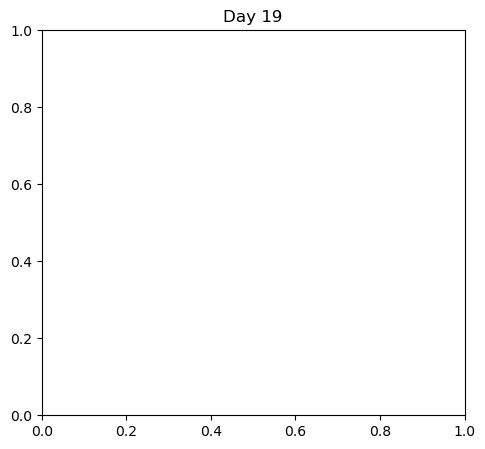

In [42]:
# rotation
from pystackreg import StackReg

sr = StackReg(StackReg.RIGID_BODY)
t1_curve_grid_transf = sr.register_transform(t0_curve_grid,t1_curve_grid)

plt.subplot(1,2,1)
plt.title('Day 19')
plt.pcolor(gridX,gridY,t0_curve_grid)
plt.clim([-1,1])

plt.subplot(1,2,2)
plt.title('Day 11')
plt.pcolor(gridX,gridY,t1_curve_grid_transf)
plt.clim([-1,1])


np.float64(0.6143804394023632)

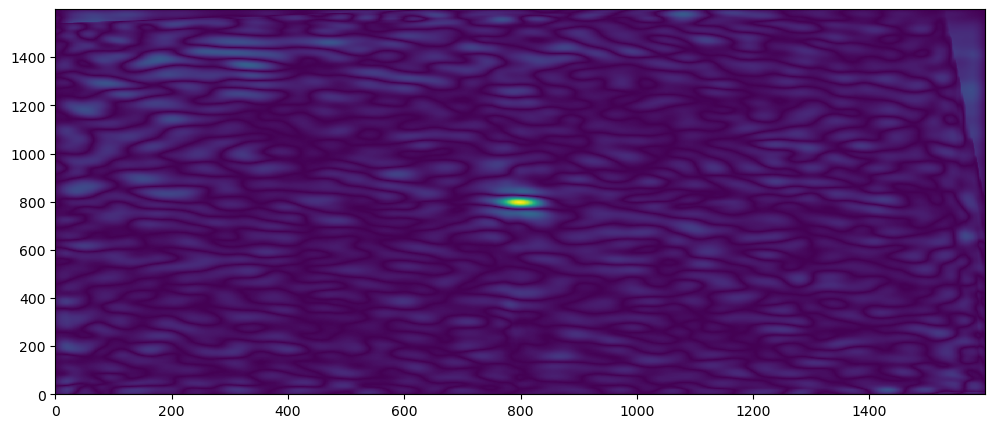

In [35]:
from mathUtils import normxcorr2

C = normxcorr2(t0_curve_grid,t1_curve_grid_transf)
plt.pcolor(C)
C.max()


# Save

In [40]:
# Plot alongside the raw images
t0_R = io.imread(path.join(dirname,'0. Day 0/R_reg.tif'))
t1_R = io.imread(path.join(dirname,'1. Day 11/R_reg.tif'))

MIP_t0_R = t0_R.max(axis=0)[Y_trim,X_trim]
MIP_t1_R = t1_R.max(axis=0)[Y_trim,X_trim]

In [66]:
t0_curve_grid.shape

(170, 170)

In [67]:
t0_curvature

array([-1.67449531, -0.54555334,  0.0944696 , ...,  0.5581811 ,
        0.50719127,  0.5701386 ])

# Use curvature to auto align time points

In [46]:
from trimesh import registration
from scipy.spatial.transform import Rotation

T,_ = registration.mesh_other(t0_mesh,t1_mesh)

pl = pv.Plotter()
pl.add_mesh(t0_mesh,color='red')
pl.add_mesh(t1_mesh)
pl.show()

Widget(value='<iframe src="http://localhost:51892/index.html?ui=P_0x35b834dd0_10&reconnect=auto" class="pyvist…

In [45]:


# transforming mesh1
t1_mesh_transformed = t1_mesh.copy()
t1_mesh_transformed.apply_transform(T)

pl = pv.Plotter()
pl.add_mesh(t0_mesh,color='red')
pl.add_mesh(t1_mesh)
pl.show()

# saving mesh1 as STL file
# mesh1.export('rigidly_aligned_mesh.stl')

Widget(value='<iframe src="http://localhost:51892/index.html?ui=P_0x3a9ea3140_9&reconnect=auto" class="pyvista…

In [47]:
T

array([[ 0.99868526,  0.01642206, -0.0485599 ,  3.4688129 ],
       [-0.01477884,  0.99931233,  0.03400659,  4.04918631],
       [ 0.04908496, -0.03324422,  0.9982412 , 11.27674525],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [33]:
from scipy import ndimage

t1_crop_transformed = ndimage.affine_transform(t1_crop,T)

stackview.slice(t1_crop)

In [5]:
import trimesh
mesh = trimesh.load_mesh('/Users/xies/Downloads/Stanford_Bunny.stl')

pl = pv.Plotter()
pl.add_mesh(pv.wrap(mesh))
pl.show()

Widget(value='<iframe src="http://localhost:56926/index.html?ui=P_0x32179a750_0&reconnect=auto" class="pyvista…

In [6]:
curv = get_tissue_curvatures(mesh)

In [9]:
curv[0].shape

(56203,)